## Working with Peter's H. Data on HS-AFM (HVG last ver.)

In this notebook we show a aplication to real AFM data and we compare with the DMD simulation

First the experimental data is loaded

In [1]:
from PIL import Image
import numpy as np
from pydmd import DMD, BOPDMD, EDMD
from pydmd.plotter import plot_eigs, plot_summary
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
import os
import imageio
from IPython.display import Image as DisplayImage
import shutil
from IPython.display import HTML
import time as time_module

In [2]:
# best result x
# poner distintos modos en el plot summary x
# modos y dinamicas en plots x
# extraer frecuencias tpdp
# 5fps

# cortar imagen del 02.tif

def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)


# Function to calculate the mass centroid
def calculate_center_of_mass(positions):
    return np.mean(positions, axis=0)

# Función to calcualte RyG
def calculate_radius_of_gyration(positions):
    com = calculate_center_of_mass(positions)
    squared_distances = np.sum((positions - com) ** 2, axis=1)  
    rg = np.sqrt(np.mean(squared_distances))  
    return rg

def get_positions_from_frames(frames):
    """
    The positions (X,Y) are obtained and stores in a array for each frame, 
    asumming the intensities of the images as distributions of the positions coordinates
    """
    positions_per_frame = []
    for frame in frames:
        y, x = np.where(frame > 0)  
        positions = np.vstack([x, y]).T  
        positions_per_frame.append(positions)
    return positions_per_frame

def get_positions_from_frames3D(frames):
    """
    The positions (X,Y) are obtained and stores in a array for each frame, 
    asumming the intensities of the images as distributions of the positions coordinates
    """
    positions_per_frame = []
    for frame in frames:
        
        y, x = np.where(frame > 0)
        
        positions = np.vstack([x, y]).T  
        positions_per_frame.append(positions)
    return positions_per_frame

def calculate_rmsd(positions_ref, positions_target):
    diff = positions_ref - positions_target
    rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
    return rmsd

def compute_rmsd_series(frames, reference_frame):
    rmsd_series = []
    for i in range(len(frames)):
        positions_ref = np.column_stack(np.where(reference_frame > 0))  
        positions_target = np.column_stack(np.where(frames[i] > 0))     
        min_size = min(len(positions_ref), len(positions_target))
        positions_ref, positions_target = positions_ref[:min_size], positions_target[:min_size]
        rmsd = calculate_rmsd(positions_ref, positions_target)
        rmsd_series.append(rmsd)
    return rmsd_series




# Generamos una funcion para los archivos en formato AVI
def read_avi(path):
    """
    Lee los frames de un archivo AVI y los devuelve como un array numpy.
    path - Ruta al archivo AVI
    """
    cap = cv2.VideoCapture(path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Convertir el frame a escala de grises (si es necesario)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()
    return np.array(frames)

def get_crop_coordinates(zones):
    crop_coords = []
    for x, y, width, height in zones:
        x_start, x_end = x, x + width
        y_start, y_end = y, y + height
        crop_coords.append((y_start, y_end, x_start, x_end))
    return crop_coords

# Generamos una funcion para los archivos en formato AVI
def calculate_areas(path,areaNoise):
    """
    Lee los frames de un archivo AVI y los devuelve como un array numpy.
    path - Ruta al archivo AVI
    """
    cap = cv2.VideoCapture(path)
    
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        exit()
    
    # List to store total area per frame
    area_per_frame = []
    
    # Minimum area threshold to filter out small noisy areas
    min_area = areaNoise  # Adjust as needed starting at 100 for us 50
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit loop when video ends
    
        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
        # Apply binary thresholding
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY) # changes 127 to 100
    
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Compute total area per frame (filter out small areas)
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]
        total_area = sum(cv2.contourArea(contour) for contour in filtered_contours)
        area_per_frame.append(total_area)
    
        # Draw and display only filtered contours
        for contour in filtered_contours:
            area = cv2.contourArea(contour)
            cv2.drawContours(frame, [contour], -1, (0, 255, 0), 2)
            cv2.putText(frame, f"Area: {int(area)} px^2", tuple(contour[0][0]), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)  # check what are those params
    
        # Display total filtered area per frame
        cv2.putText(frame, f"Total Area: {int(total_area)} px^2", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2) # check what are those params
        
        cv2.imshow("Segment Area Detection", frame)
    
        # Press 'q' to quit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    
    # Convert list to NumPy array
    area_per_frame = np.array(area_per_frame)
    
    # Print the total area per frame (optional)
    print("Total Area per Frame:", area_per_frame)
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()    
        
    return np.array(area_per_frame)

def obtain_xyz(path):

    # Load the AVI video
    cap = cv2.VideoCapture(path)
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()
    
    # Store all frame data
    all_frames_data = []
    
    frame_idx = 0  # Track frame number
    
    while True:
        ret, frame = cap.read()  # Read a frame
        
        if not ret:
            break  # Exit loop when video ends
    
        # Convert to grayscale (Z value)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
        # Get frame dimensions
        h, w = gray_frame.shape  
    
        # Create coordinate grid for X, Y values
        y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    
        # Flatten arrays to save (Frame, X, Y, Z_Gray)
        frame_array = np.column_stack((np.full(h*w, frame_idx), x_coords.ravel(), y_coords.ravel(), gray_frame.ravel()))
    
        # Append frame data
        all_frames_data.append(frame_array)
        
        frame_idx += 1  # Increment frame number
    
        # Display frame (optional)
        cv2.imshow("Video", gray_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Convert to NumPy array and save
    all_frames_data = np.vstack(all_frames_data)  # Stack all frames
    np.save("frames_data.npy", all_frames_data)
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

# Load and check saved data
#loaded_data = np.load("frames_data.npy")
#print("Sample saved data (first 5 rows):\n", loaded_data[:5])    


The data is fitted with a `DMD` model with $r=10$ modes

    :param tol: The tolerance for the relative error in the residual.
        i.e. the program will terminate if
            norm(y-Phi(alpha)*b,'fro')/norm(y,'fro') < tol
        is achieved. Default is 1e-6.

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to tar

n_frames, width, height (204, 90, 90)
Step 1 Error 0.3020470396313328 Lambda 2048.0
Step 2 Error 0.29749382817550135 Lambda 8192.0
Step 3 Error 0.29556861553833513 Lambda 2730.6666666666665
Step 4 Error 0.294572191306595 Lambda 910.2222222222222
Step 5 Error 0.2937773758594104 Lambda 303.4074074074074
Step 6 Error 0.2932137993444566 Lambda 9709.037037037036
Step 7 Error 0.2922579299235927 Lambda 3236.3456790123455
Step 8 Error 0.29159631612519393 Lambda 12945.382716049382
Step 9 Error 0.2911219787687297 Lambda 4315.12757201646
Step 10 Error 0.29081161242060843 Lambda 8630.25514403292
Step 11 Error 0.29049192596679285 Lambda 2876.75171467764
Step 12 Error 0.29026735109164753 Lambda 5753.50342935528
Step 13 Error 0.2901368196997009 Lambda 1917.8344764517599
Step 14 Error 0.29004558281448123 Lambda 7671.3379058070395
Step 15 Error 0.2899301428163952 Lambda 15342.675811614079
Step 16 Error 0.2898485507624267 Lambda 5114.225270538026
Step 17 Error 0.28980948879611984 Lambda 10228.4505410760

/home/hache/miniconda3/lib/python3.9/site-packages/pydmd/bopdmd.py:812: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


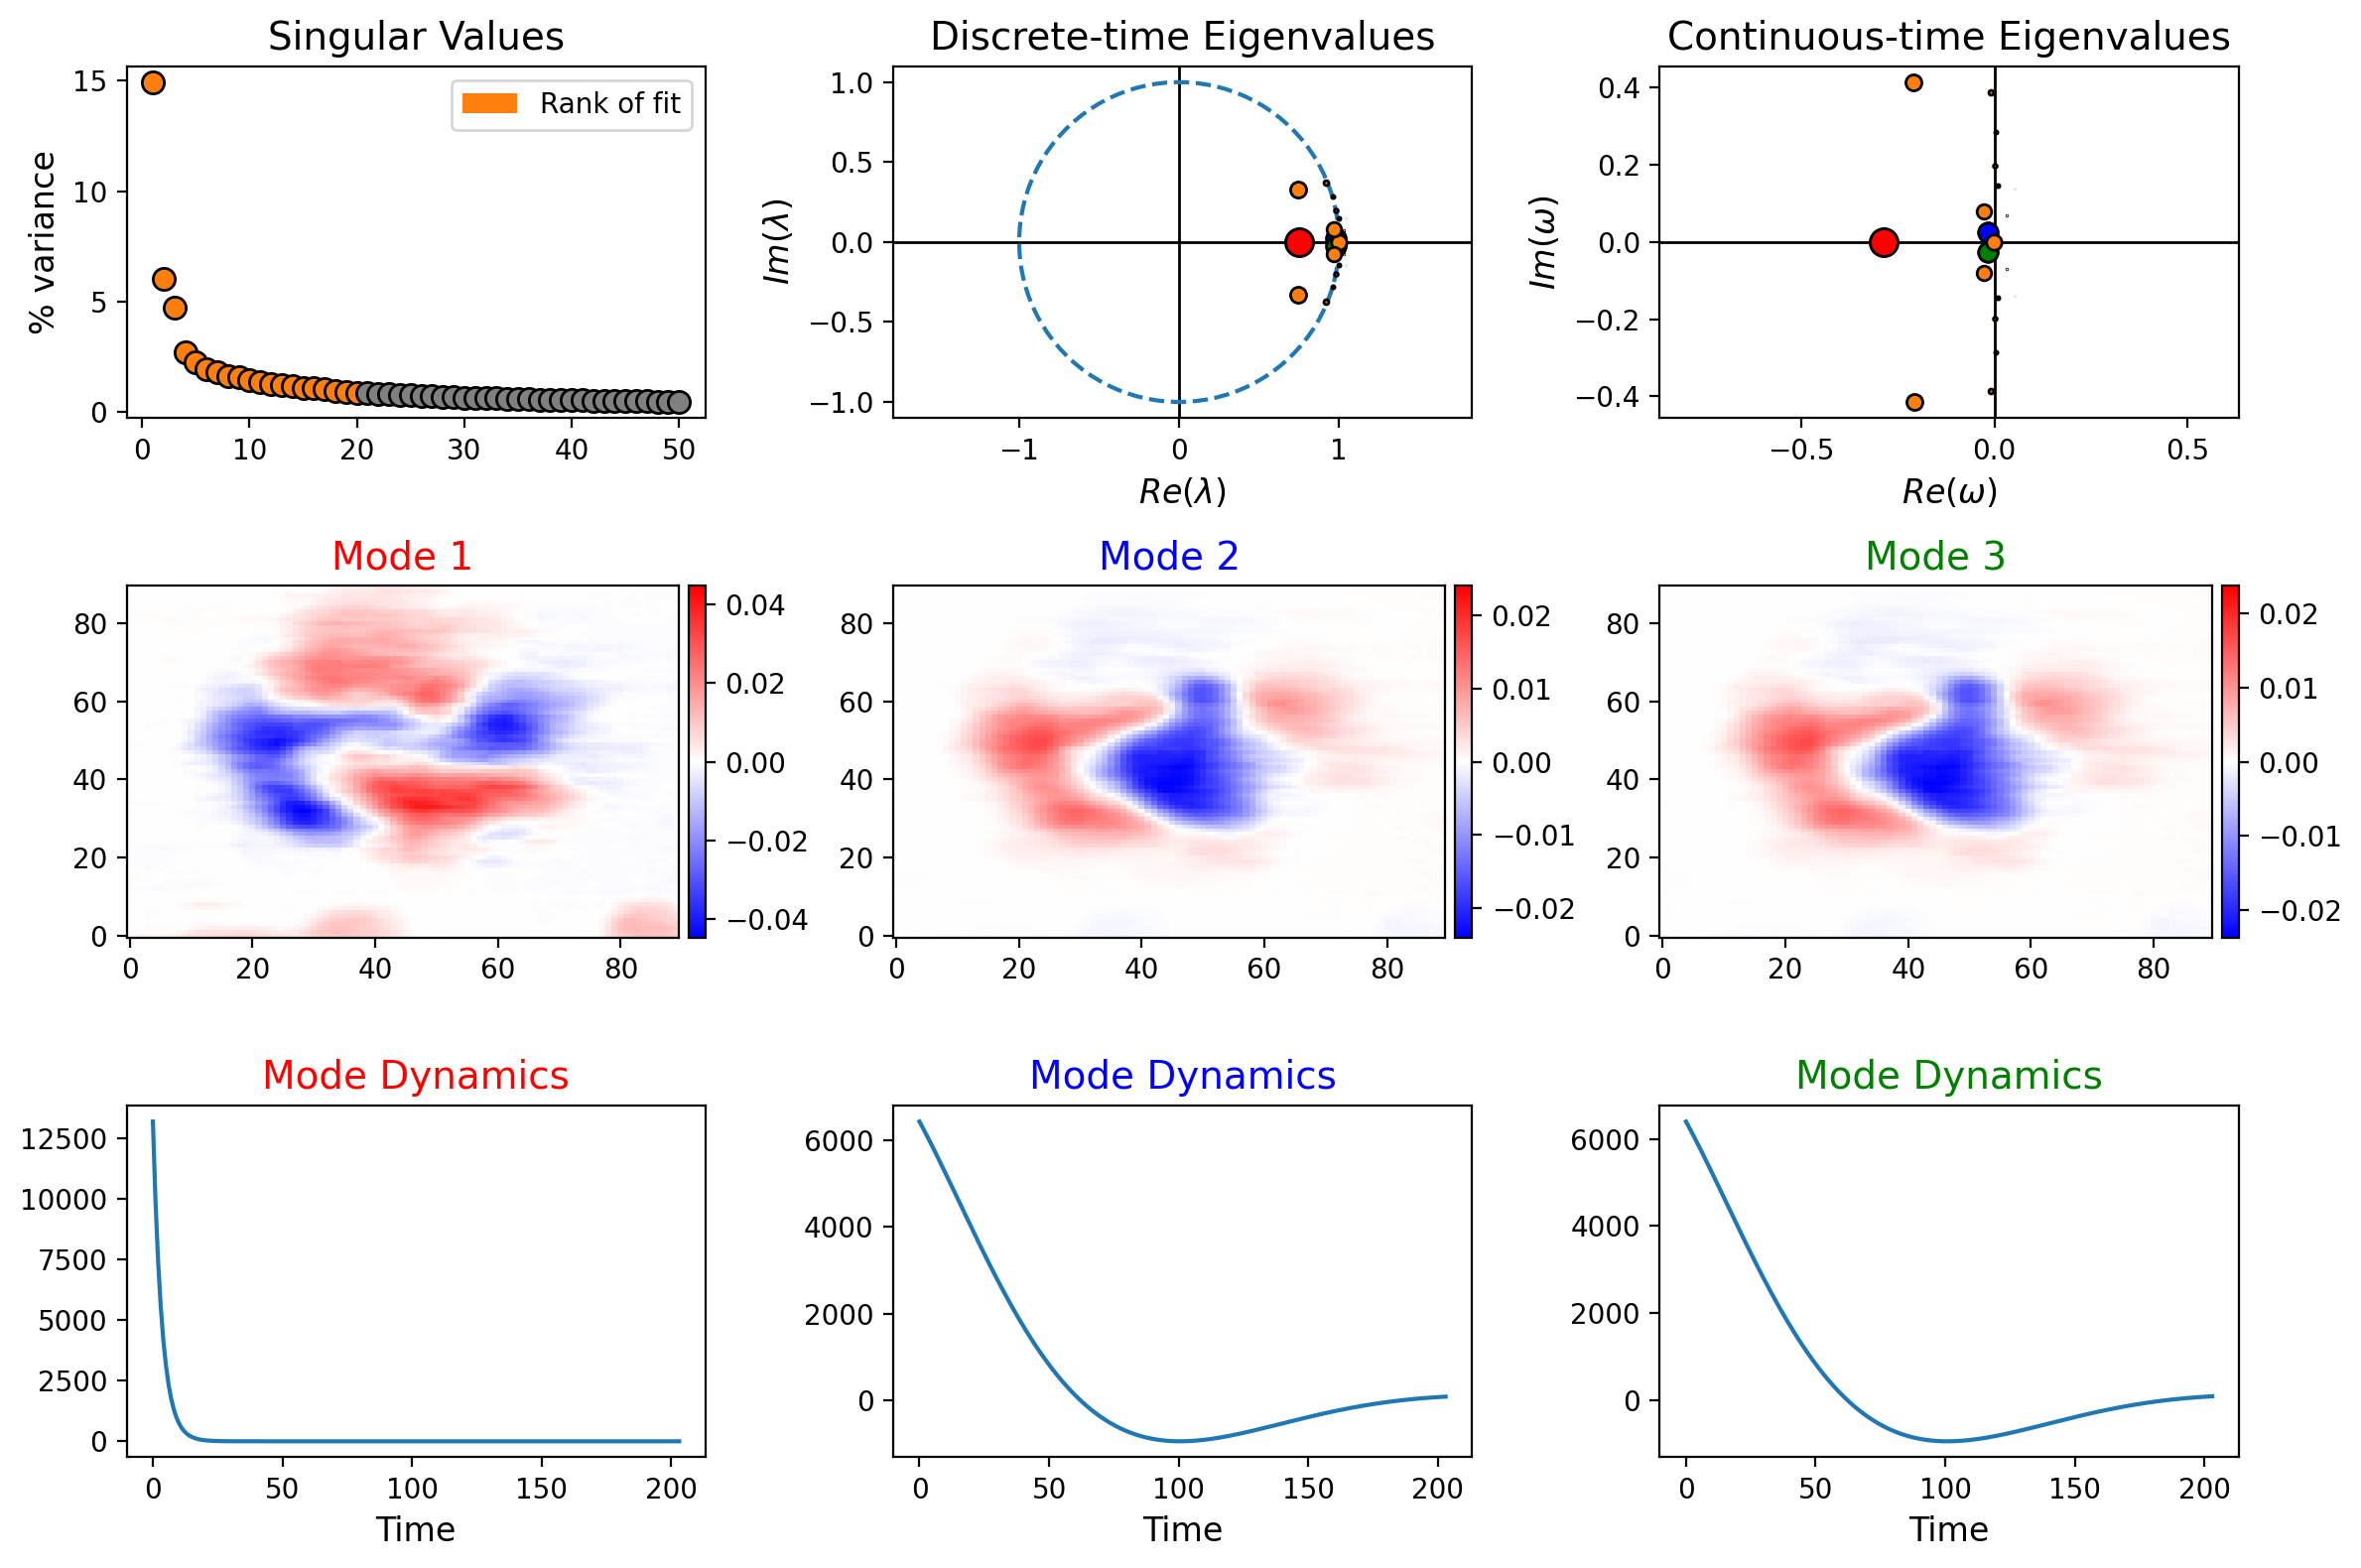

In [3]:
#%matplotlib inline
obtain_xyz('spikes/Images 0.6 gauss z 6 nm.avi')
frames = read_avi('spikes/Images 0.6 gauss z 6 nm.avi')

umbral = 0 #parameter to try to get rid of the noise!
frames= np.where(frames < umbral, 0, frames)

frames = frames[12:216,10:90,10:90]   # New, not using our own filter  ,  the filter is also 10-90

print(f'n_frames, width, height {frames.shape}')
X = frames.reshape(frames.shape[0],frames.shape[1]*frames.shape[1]).T


optdmd = BOPDMD(svd_rank=20,varpro_opts_dict={"verbose":True}) #uncomment to add options 5 good
#dmd = DMD(svd_rank=4)
optdmd.fit(X,np.linspace(0,frames.shape[0]-1,frames.shape[0])) #.2*np.linspace(0,169,170) np.linspace(0,frames.shape[0]-1,frames.shape[0])

# Plot a summary of the DMD results.
plot_summary(optdmd,snapshots_shape=(frames.shape[1],frames.shape[1]))

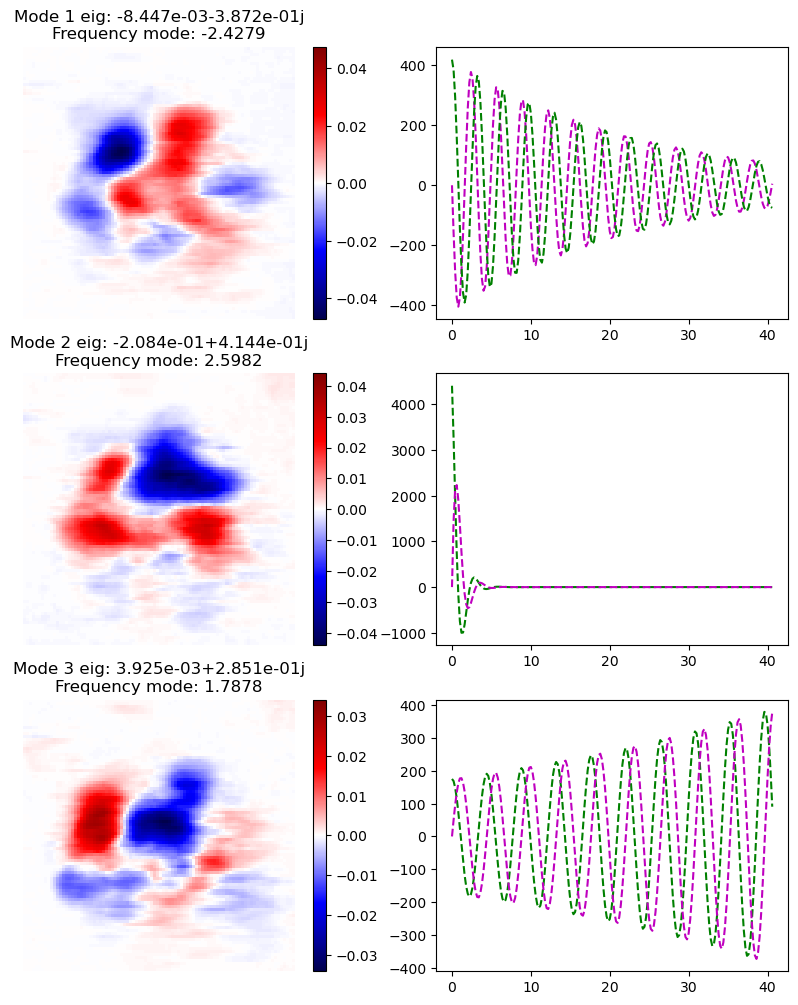

In [4]:
mode1 = 1
mode2 = 2 
mode3 = 4

fps = 1/ 6.27 
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

im1 = axs[0, 0].imshow(np.real(optdmd.modes[:, mode1].reshape(frames.shape[1], frames.shape[1])), cmap='seismic', vmin=-np.max(np.abs(np.real(optdmd.modes[:, mode1]))), vmax=np.max(np.abs(np.real(optdmd.modes[:, mode1]))))
im2 = axs[1, 0].imshow(np.real(optdmd.modes[:, mode2].reshape(frames.shape[1], frames.shape[1])), cmap='seismic', vmin=-np.max(np.abs(np.real(optdmd.modes[:, mode2]))), vmax=np.max(np.abs(np.real(optdmd.modes[:, mode2]))))
im3 = axs[2, 0].imshow(np.real(optdmd.modes[:, mode3].reshape(frames.shape[1], frames.shape[1])), cmap='seismic', vmin=-np.max(np.abs(np.real(optdmd.modes[:, mode3]))), vmax=np.max(np.abs(np.real(optdmd.modes[:, mode3]))))

axs[0, 1].plot(0.2 * np.linspace(0, 203, 204), np.imag(optdmd.dynamics[mode1, :]),'m--') #Imaginario
axs[0, 1].plot(0.2 * np.linspace(0, 203, 204), np.real(optdmd.dynamics[mode1, :]),'g--') #G
axs[1, 1].plot(0.2 * np.linspace(0, 203, 204), np.real(optdmd.dynamics[mode2, :]),'g--')
axs[1, 1].plot(0.2 * np.linspace(0, 203, 204), np.imag(optdmd.dynamics[mode2, :]),'m--')
axs[2, 1].plot(0.2 * np.linspace(0, 203, 204), np.real(optdmd.dynamics[mode3, :]),'g--')
axs[2, 1].plot(0.2 * np.linspace(0, 203, 204), np.imag(optdmd.dynamics[mode3, :]),'m--')

axs[0, 0].set_title(f'Mode 1 eig: {optdmd.eigs[mode1]:.3e}\nFrequency mode: {(optdmd.eigs[mode1].imag / fps):.4f}')
axs[1, 0].set_title(f'Mode 2 eig: {optdmd.eigs[mode2]:.3e}\nFrequency mode: {(optdmd.eigs[mode2].imag / fps):.4f}')
axs[2, 0].set_title(f'Mode 3 eig: {optdmd.eigs[mode3]:.3e}\nFrequency mode: {(optdmd.eigs[mode3].imag / fps):.4f}')

axs[0, 0].set_axis_off()
axs[1, 0].set_axis_off()
axs[2, 0].set_axis_off()

fig.colorbar(im1, ax=axs[0, 0], orientation='vertical')
fig.colorbar(im2, ax=axs[1, 0], orientation='vertical')
fig.colorbar(im3, ax=axs[2, 0], orientation='vertical')

Relation frequencies and dmd-eigenvalues from official `PyDMD` documentation https://github.com/PyDMD/PyDMD/blob/master/tutorials/tutorial1/tutorial-1-dmd.ipynb

$$
f = \frac{\ln(\lambda)}{\Delta t}
$$

Where $f$ is in $(Hz)$ units. In this case 5 fps is equal to $\Delta t = 0.2 (s)$. Check the tutorial because it's not consistent with the definition of frequencies 

The decomposition is compared with the experimental data in 3 different snapshots

In [5]:
'''dmd_umb = np.real(optdmd.reconstructed_data)
umbral_dmd = 0
dmd_umb= np.where(dmd_umb < umbral_dmd, 0, dmd_umb)
print(np.max(dmd_umb))'''

'dmd_umb = np.real(optdmd.reconstructed_data)\numbral_dmd = 0\ndmd_umb= np.where(dmd_umb < umbral_dmd, 0, dmd_umb)\nprint(np.max(dmd_umb))'

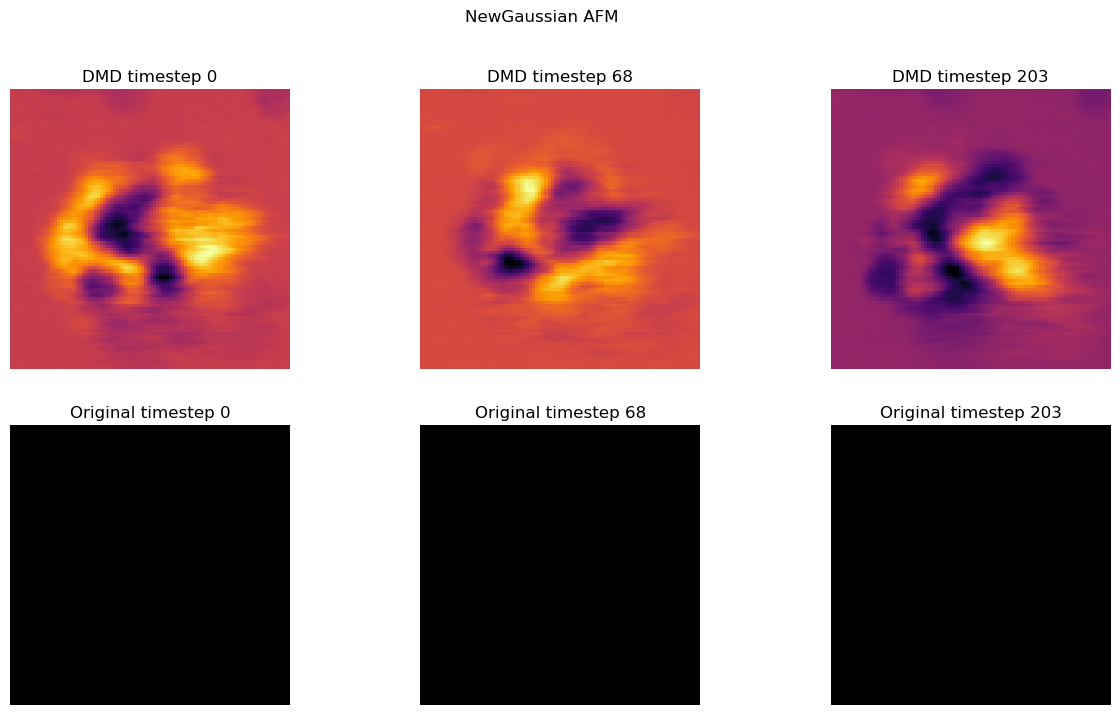

In [6]:

fig, axs = plt.subplots(2,3,figsize=(15,8))
timesteps = (0,frames.shape[0]//3,frames.shape[0]-1)
axs[0,0].imshow(np.imag(optdmd.reconstructed_data[:,0]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,1].imshow(np.imag(optdmd.reconstructed_data[:,frames.shape[0]//3]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,2].imshow(np.imag(optdmd.reconstructed_data[:,frames.shape[0]-1]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,0].imshow(np.imag(X[:,0]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,1].imshow(np.imag(X[:,frames.shape[0]//3]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,2].imshow(np.imag(X[:,frames.shape[0]-1]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,0].set_title(f'DMD timestep {timesteps[0]}'); 
axs[0,1].set_title(f'DMD timestep {timesteps[1]}'); 
axs[0,2].set_title(f'DMD timestep {timesteps[2]}'); 
axs[1,0].set_title(f'Original timestep {timesteps[0]}'); 
axs[1,1].set_title(f'Original timestep {timesteps[1]}'); 
axs[1,2].set_title(f'Original timestep {timesteps[2]}'); 
axs[0,0].set_axis_off(); axs[0,1].set_axis_off();  axs[0,2].set_axis_off(); 
axs[1,0].set_axis_off(); axs[1,1].set_axis_off();  axs[1,2].set_axis_off(); 
fig.suptitle('NewGaussian AFM')
fig.savefig('NewGaussian.png')

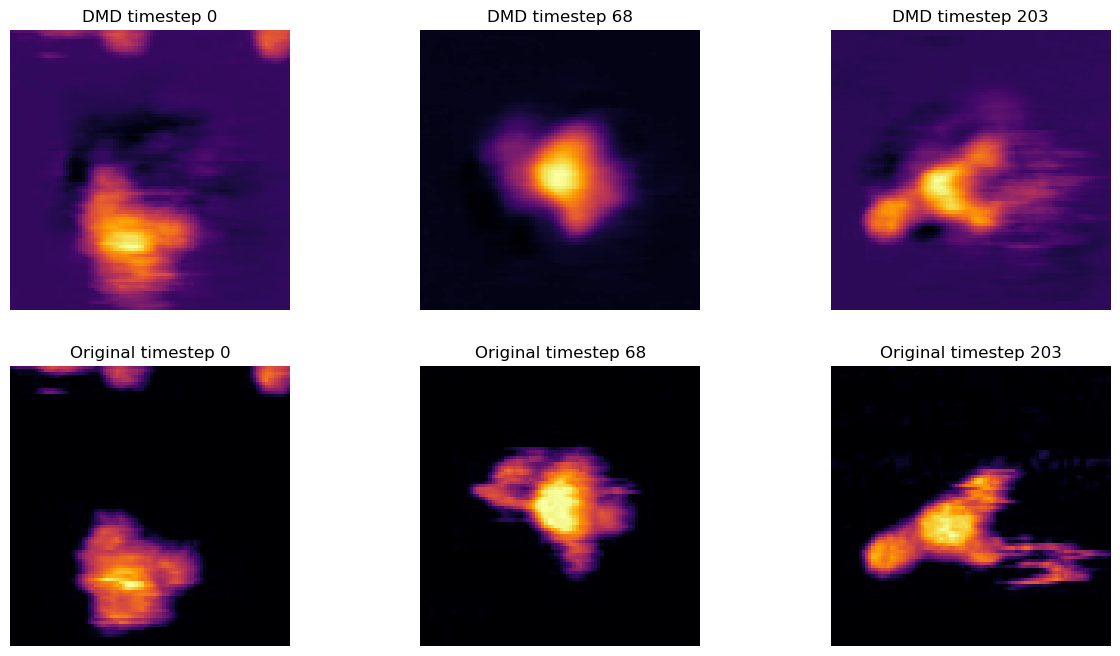

In [7]:

fig, axs = plt.subplots(2,3,figsize=(15,8))
timesteps = (0,frames.shape[0]//3,frames.shape[0]-1)
axs[0,0].imshow(np.real(optdmd.reconstructed_data[:,0]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,1].imshow(np.real(optdmd.reconstructed_data[:,frames.shape[0]//3]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,2].imshow(np.real(optdmd.reconstructed_data[:,frames.shape[0]-1]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,0].imshow(np.real(X[:,0]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,1].imshow(np.real(X[:,frames.shape[0]//3]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,2].imshow(np.real(X[:,frames.shape[0]-1]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,0].set_title(f'DMD timestep {timesteps[0]}'); 
axs[0,1].set_title(f'DMD timestep {timesteps[1]}'); 
axs[0,2].set_title(f'DMD timestep {timesteps[2]}'); 
axs[1,0].set_title(f'Original timestep {timesteps[0]}'); 
axs[1,1].set_title(f'Original timestep {timesteps[1]}'); 
axs[1,2].set_title(f'Original timestep {timesteps[2]}'); 
axs[0,0].set_axis_off(); axs[0,1].set_axis_off();  axs[0,2].set_axis_off(); 
axs[1,0].set_axis_off(); axs[1,1].set_axis_off();  axs[1,2].set_axis_off(); 
#fig.suptitle('SV012 AFM')
fig.savefig('afm_dmd_reconstruction_sarahNewGaussian.png')





In [8]:
def comp_rg_3D(data,xfact,yfact,zfact,thre):

    frames = np.unique(data[:, 0]).astype(int)
    #print(frames)
    # Store radius of gyration for each frame
    Rg_per_frame = []
    Rg_parallel= []
    Rg_perp= []
    for frame in frames:
        # Select data for current frame
        frame_data = data[data[:, 0] == frame]
        
        # Extract X, Y, Z positions
        X = frame_data[:, 1]*xfact
        Y = frame_data[:, 2]*yfact
        Z = frame_data[:, 3]  # Grayscale intensity as Z-value
        X= np.where(Z < thre, 0, X)
        Y= np.where(Z < thre, 0, Y)
        Z= np.where(Z < thre, 0, Z)*zfact
        # Compute center of mass (COM)
        x_cm = np.mean(X)
        y_cm = np.mean(Y)
        z_cm = np.mean(Z)
    
        # Compute squared distance from COM
        squared_distances = (X - x_cm) ** 2 + (Y - y_cm) ** 2 + (Z - z_cm) ** 2
        parallel=(X - x_cm) ** 2 + (Y - y_cm) ** 2
        perp=(Z - z_cm) ** 2
    
        # Compute radius of gyration
        Rg = np.sqrt(np.mean(squared_distances))
        rgpar=np.sqrt(np.mean(parallel))
        rgperp=np.sqrt(np.mean(perp))
        # Save result
        Rg_per_frame.append([frame, Rg])
        Rg_parallel.append([frame, rgpar])
        Rg_perp.append([frame, rgperp])
    return np.array(Rg_per_frame),np.array(Rg_parallel),np.array(Rg_perp)

In [9]:
loaded_data = np.load("frames_data.npy")
Rg_series,Rg_par,Rg_perp=comp_rg_3D(loaded_data,0.8,0.8,0.0235,100)  #0.039 is the factor for the height  Updated to height 6 nm ... 0.0235
Rg_series=Rg_series[12:216,:]
Rg_par=Rg_par[12:216,:]
Rg_perp=Rg_perp[12:216,:]
#Rg_series[:,1]

In [10]:
Rg_par

array([[ 12.        ,  19.53425674],
       [ 13.        ,  20.65934835],
       [ 14.        ,  10.9144443 ],
       [ 15.        ,  12.77314535],
       [ 16.        ,  13.83902135],
       [ 17.        ,  12.91324412],
       [ 18.        ,  14.37546971],
       [ 19.        ,  12.28263602],
       [ 20.        ,  14.07030223],
       [ 21.        ,  13.1422561 ],
       [ 22.        ,  15.48212734],
       [ 23.        ,  15.21093488],
       [ 24.        ,  13.57913302],
       [ 25.        ,  14.46150429],
       [ 26.        ,  13.5644406 ],
       [ 27.        ,  14.96857903],
       [ 28.        ,  14.89821259],
       [ 29.        ,  14.67119483],
       [ 30.        ,  14.35061655],
       [ 31.        ,  13.31875315],
       [ 32.        ,  12.31903798],
       [ 33.        ,  16.64442449],
       [ 34.        ,  13.88848033],
       [ 35.        ,  12.79040053],
       [ 36.        ,  15.23440186],
       [ 37.        ,  16.00565935],
       [ 38.        ,  14.38839222],
 

mean Rg AFM: 14.803438777591515


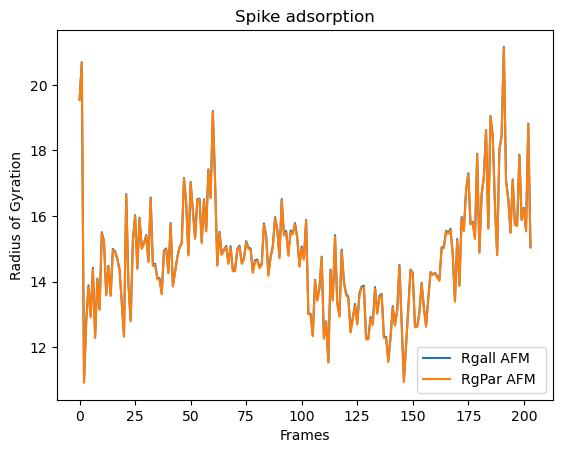

In [11]:
# Graficar radios de giro
plt.plot(Rg_series[:,1], label="Rgall AFM ");plt.plot(Rg_par[:,1], label="RgPar AFM ")
plt.xlabel("Frames"); plt.ylabel("Radius of Gyration");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_All.png');
#print("minima",rgyr_dmd)
#rgyr_original=np.array(rgyr_original)
print("mean Rg AFM:", np.array(Rg_series[:,1]).mean())

In [12]:
32*0.8*0.8

20.480000000000004

mean Rg AFM: 0.9368551537737023


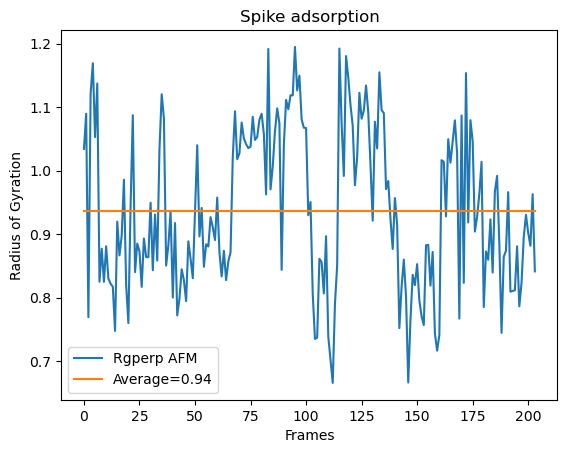

In [13]:
plt.plot(Rg_perp[:,1], label="Rgperp AFM ")
plt.xlabel("Frames"); plt.ylabel("Radius of Gyration");plt.plot(np.ones(Rg_perp[:,1].size)*Rg_perp[:,1].mean(), label="Average="+str(np.round(Rg_perp[:,1].mean(),2)))
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_All.png');
#print("minima",rgyr_dmd)
#rgyr_original=np.array(rgyr_original)
print("mean Rg AFM:", np.array(Rg_perp[:,1]).mean())

In [14]:
frames.shape
z=frames[0][frames[0][0][1],frames[0][0][0]]
print(z)

49


In [15]:
frames[0][1]


array([  1,   4,  10,   5,   1,   3,   4,  12,  27,  52,  74, 111, 116,
       116, 107, 102, 107, 113, 116, 107,  96,  80,  66,  56,  47,  40,
        35,  33,  38,  59,  89, 111, 120, 131, 142, 136, 133, 121, 112,
       107, 104,  96,  87,  67,  55,  36,  18,   5,   1,   0,   1,   1,
         1,   1,   1,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   6,  32,
        70, 109, 133, 151, 163, 161, 153, 144, 142, 133, 123, 114],
      dtype=uint8)

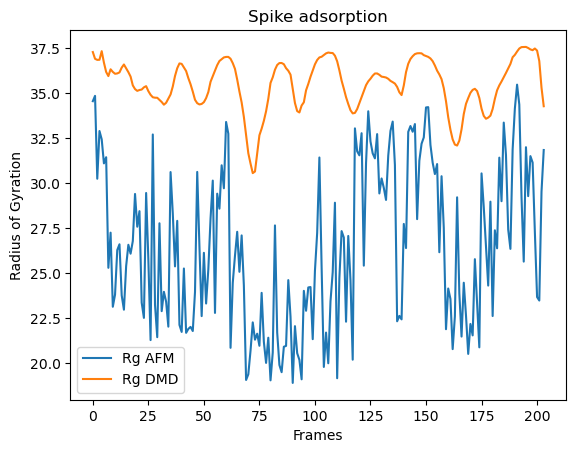

mean Rg AFM: 26.448719435230043


In [16]:
# Extract DMD and experimental coordinates
original_positions = get_positions_from_frames(X.T.reshape(frames.shape))
dmd_positions = get_positions_from_frames(optdmd.reconstructed_data.T.reshape(frames.shape))

# Calculate RyG
rgyr_original = [calculate_radius_of_gyration(positions) for positions in original_positions]
rgyr_dmd = [calculate_radius_of_gyration(positions) for positions in dmd_positions]

# Graficar radios de giro
plt.plot(rgyr_original, label="Rg AFM "); plt.plot(rgyr_dmd, label="Rg DMD");
plt.xlabel("Frames"); plt.ylabel("Radius of Gyration");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_DMD_sv012.png');
plt.show();
#print("minima",rgyr_dmd)
rgyr_original=np.array(rgyr_original)
print("mean Rg AFM:", np.array(rgyr_original).mean())

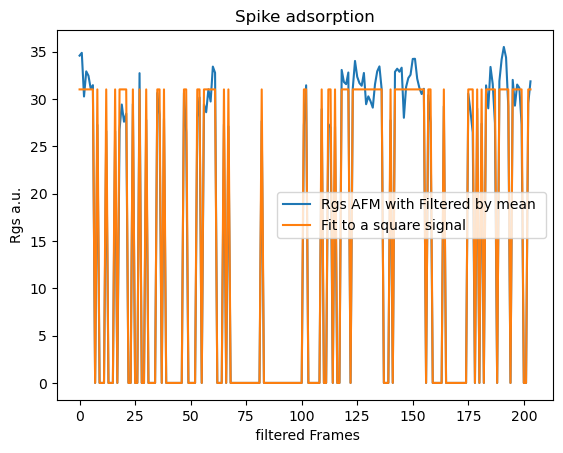

min 18.88971418463938
max 35.486416542086204
mean 26.448719435230043


In [17]:
umbralRgs = rgyr_original.mean() #parameter to try to get rid of the noise!
rgyr_originalFilt= np.where(rgyr_original < umbralRgs, 0, rgyr_original)
plt.plot(rgyr_originalFilt, label="Rgs AFM with Filtered by mean "); plt.plot(np.where(rgyr_originalFilt>rgyr_originalFilt.mean(),31,0), label="Fit to a square signal")
plt.xlabel(" filtered Frames"); plt.ylabel("Rgs a.u.");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_filtered.png');
plt.show();
print("min",rgyr_original.min())
print("max",rgyr_original.max())
print("mean",rgyr_original.mean())

In [18]:
rgyr_originalFilt

array([34.56657404, 34.86352955, 30.2510966 , 32.90534972, 32.44205406,
       31.10464718, 31.44972894,  0.        , 27.25045653,  0.        ,
        0.        ,  0.        , 26.60413285,  0.        ,  0.        ,
        0.        , 26.57769332,  0.        , 26.78447353, 29.40428603,
       27.58131832, 28.447184  ,  0.        ,  0.        , 29.458385  ,
        0.        ,  0.        , 32.71379101,  0.        ,  0.        ,
       27.77282745,  0.        ,  0.        ,  0.        ,  0.        ,
       30.62228269, 28.32227301,  0.        , 27.90850325,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 30.63002487, 26.4654276 ,  0.        ,
        0.        ,  0.        ,  0.        , 28.03795321, 30.14782455,
        0.        , 29.41970733, 28.5864272 , 30.99975271, 29.72023574,
       33.41023958, 32.75736572,  0.        ,  0.        ,  0.        ,
       27.29949089,  0.        , 27.09764868,  0.        ,  0.  

In [19]:
indexesHighRg=np.array(range(0,204))*np.where(rgyr_originalFilt>rgyr_originalFilt.mean(),1,0)
print(indexesHighRg)
type(indexesHighRg)
transition_indicesRg = np.where((indexesHighRg[:-1] == 0) & (indexesHighRg[1:] != 0))[0] + 1

outTransIdexesRg=indexesHighRg[transition_indicesRg]
print(outTransIdexesRg)
print(outTransIdexesRg.size)

[  0   1   2   3   4   5   6   0   8   0   0   0  12   0   0   0  16   0
  18  19  20  21   0   0  24   0   0  27   0   0  30   0   0   0   0  35
  36   0  38   0   0   0   0   0   0   0   0  47  48   0   0   0   0  53
  54   0  56  57  58  59  60  61   0   0   0  65   0  67   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  82   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 101 102   0   0   0   0   0
   0 109   0   0 112 113   0 115   0   0 118 119 120 121   0 123 124 125
 126 127 128 129 130 131 132 133 134 135 136   0   0   0 140   0 142 143
 144 145 146 147 148 149 150 151 152 153 154 155   0 157 158   0   0   0
   0   0 164   0   0   0   0   0   0   0   0   0   0 175 176 177   0 179
   0 181   0 183 184 185 186 187   0 189 190 191 192 193   0 195 196 197
 198 199   0   0 202 203]
[  1   8  12  16  18  24  27  30  35  38  47  53  56  65  67  82 101 109
 112 115 118 123 140 142 157 164 175 179 181 183 189 195 202]
33


[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


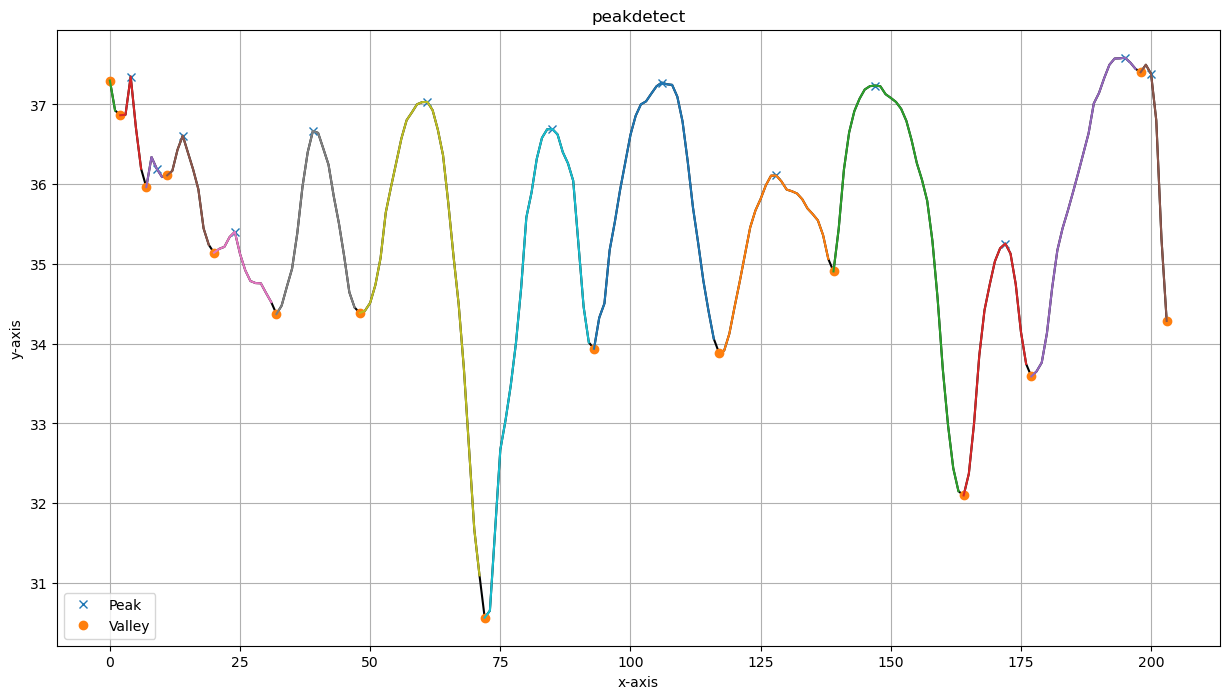

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [20]:
from findpeaks import findpeaks
rgyr_dmdarr=np.asarray(rgyr_dmd)
fp = findpeaks(lookahead=1)
results=fp.fit(rgyr_dmdarr)
fp.plot()

204
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4      37.349727
         ...    
199     0.000000
200    37.383180
201     0.000000
202     0.000000
203     0.000000
Length: 204, dtype: float64


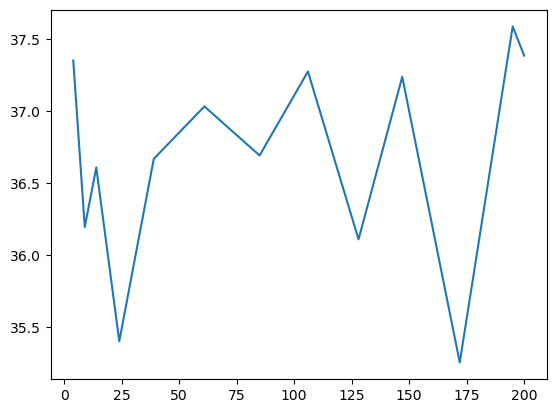

In [21]:
valleyArr=results['df']['peak'] # choose between "peak" or  "valley"
xArr=results['df']['x']
yArr=results['df']['y']
#Array multiplication
multipArrX=valleyArr*xArr
print(multipArrX.size)
multipArrY=valleyArr*yArr
print(multipArrY)
newX=np.nonzero(multipArrX)
framesTop=np.asarray(xArr)[newX]
rgTop=np.asarray(yArr)[newX]
plt.plot(framesTop,rgTop)


In [24]:
index2Plot=framesTop[rgTop<37.7]  #  where is 32.8 coming from?
print(index2Plot.size)
print(index2Plot)

13
[  4   9  14  24  39  61  85 106 128 147 172 195 200]


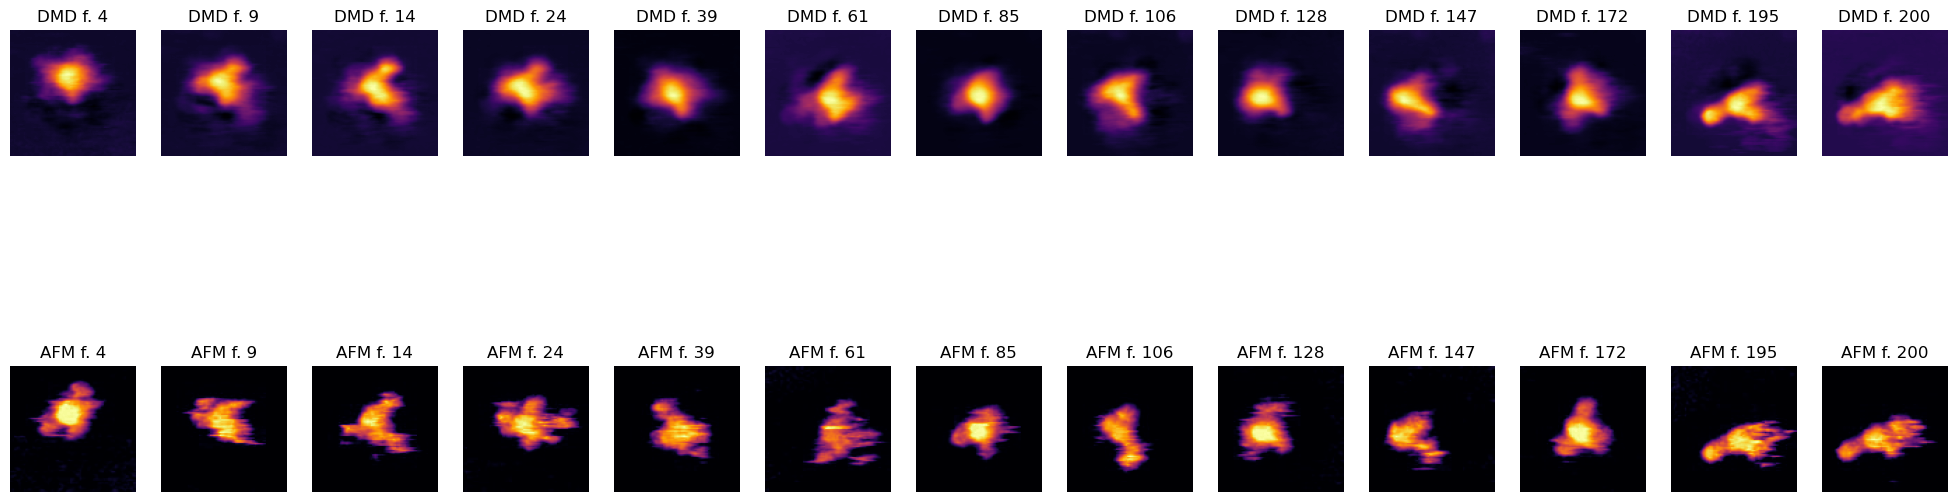

In [25]:
fig, axs = plt.subplots(2,index2Plot.size,figsize=(25,8))
timesteps = index2Plot
for i in range(0,index2Plot.size):
    axs[0,i].imshow(np.real(optdmd.reconstructed_data[:,index2Plot[i]]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
    axs[1,i].imshow(np.real(X[:,index2Plot[i]]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
    axs[0,i].set_title(f'DMD f. {timesteps[i]}');
    axs[1,i].set_title(f'AFM f. {timesteps[i]}');
    axs[0,i].set_axis_off()
    axs[1,i].set_axis_off()
plt.show()    
fig.savefig('afm_dmd_reconstruction_sarahNewGaussian.png')    
    


'''
axs[0,0].imshow(np.real(optdmd.reconstructed_data[:,109]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,1].imshow(np.real(optdmd.reconstructed_data[:,159]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,2].imshow(np.real(optdmd.reconstructed_data[:,189]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,0].imshow(np.real(X[:,109]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,1].imshow(np.real(X[:,159]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[1,2].imshow(np.real(X[:,189]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
axs[0,0].set_title(f'DMD timestep {timesteps[0]}'); 
axs[0,1].set_title(f'DMD timestep {timesteps[1]}'); 
axs[0,2].set_title(f'DMD timestep {timesteps[2]}'); 
axs[1,0].set_title(f'Original timestep {timesteps[0]}'); 
axs[1,1].set_title(f'Original timestep {timesteps[1]}'); 
axs[1,2].set_title(f'Original timestep {timesteps[2]}'); 
axs[0,0].set_axis_off(); axs[0,1].set_axis_off();  axs[0,2].set_axis_off(); 
axs[1,0].set_axis_off(); axs[1,1].set_axis_off();  axs[1,2].set_axis_off(); 
'''
#fig.suptitle('SV012 AFM')
fig.savefig('afm_dmd_reconstruction_sarah.png') 


In [26]:
areaTpframe = calculate_areas('spikes/Horcaio-spike.avi',100)  #min area to filter is given in a.u.
areaTpframe = areaTpframe[12:216] 


QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to target thread (0x588f20b49740)

QObject::moveToThread: Current thread (0x588f20b49740) is not the object's thread (0x588f1fc73c40).
Cannot move to tar

Total Area per Frame: [ 831.  1227.5 1068.   653.   700.   834.5 1036.  1098.  1460.  1300.5
 1429.5 1371.5 1116.5 1517.5  894.5  783.   867.5  728.5  811.   893.5
  916.   867.5 1045.5 1245.   877.5 1030.5  984.   954.   949.5  965.5
  807.5  936.   894.5 1079.5  719.5  704.5 1104.  1217.5 1007.  1154.
 1074.5  936.5  874.5  942.  1100.   872.   730.   665.5  718.5  845.
 1066.   898.  1002.5 1038.5  934.  1077.5  985.5  819.5  929.5 1089.
 1051.   877.5  989.5  832.5  816.5  814.5 1037.   789.5  929.5  603.5
 1149.   896.  1127.5  853.5  865.   899.   916.5  810.5  820.5  681.5
  822.   644.   665.   698.5  714.5  743.5  669.5  766.   738.5  752.5
  645.   649.5  625.5  636.5  725.5  732.   739.5  640.5  674.5  675.5
  755.  1000.5  655.5  864.5  791.5  773.5  730.   722.5  764.   816.
  792.   703.5  652.   876.   920.   979.   790.5  763.   734.5  734.5
  808.5  784.5  633.   696.   697.5  946.5  736.5  758.5  663.   645.
  813.5  691.   670.5  705.5  531.5  701.   727.   648.5  69

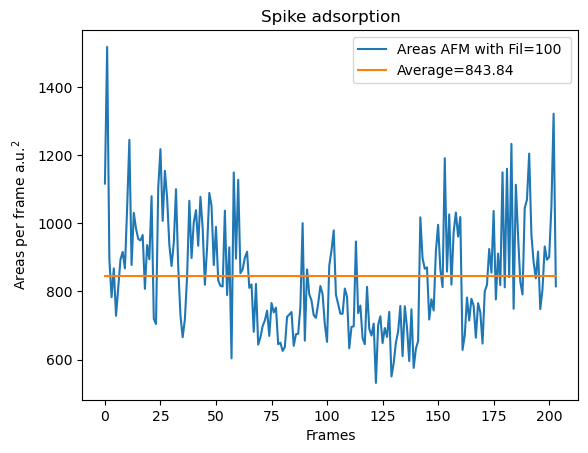

min 531.5
max 1517.5
mean 843.8357843137255


In [27]:
# Graficar areas per Frame
plt.plot(areaTpframe, label="Areas AFM with Fil=100 ");plt.plot(np.ones(areaTpframe.size)*areaTpframe.mean(), label="Average="+str(np.round(areaTpframe.mean(),2)))
plt.xlabel("Frames"); plt.ylabel("Areas per frame a.u.$^2$");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_areas.png');
plt.show();
print("min",areaTpframe.min())
print("max",areaTpframe.max())
print("mean",areaTpframe.mean())

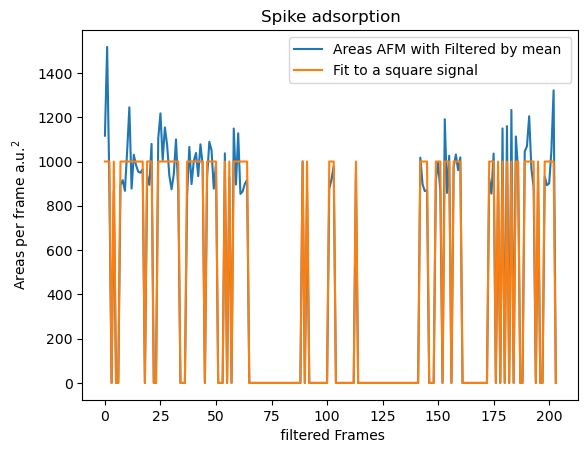

min 0.0
max 1517.5
mean 438.1397058823529


In [28]:
umbralAreas = areaTpframe.mean() #parameter to try to get rid of the noise!
areaTpframeFilt= np.where(areaTpframe < umbralAreas, 0, areaTpframe)
plt.plot(areaTpframeFilt, label="Areas AFM with Filtered by mean "); plt.plot(np.where(areaTpframeFilt>areaTpframeFilt.mean(),1000,0), label="Fit to a square signal")
plt.xlabel(" filtered Frames"); plt.ylabel("Areas per frame a.u.$^2$");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_areas.png');
plt.show();
print("min",areaTpframeFilt.min())
print("max",areaTpframeFilt.max())
print("mean",areaTpframeFilt.mean())

In [29]:
indexesHigh=np.array(range(0,204))*np.where(areaTpframeFilt>areaTpframeFilt.mean(),1,0)
print(indexesHigh)
type(indexesHigh)
transition_indices = np.where((indexesHigh[:-1] == 0) & (indexesHigh[1:] != 0))[0] + 1

outTransIdexes=indexesHigh[transition_indices]
print(outTransIdexes)
print(outTransIdexes.size)

[  0   1   2   0   4   0   0   7   8   9  10  11  12  13  14  15  16  17
   0  19  20  21   0   0  24  25  26  27  28  29  30  31  32  33   0   0
   0  37  38  39  40  41  42  43  44   0  46  47  48  49  50   0   0   0
  54   0  56   0  58  59  60  61  62  63  64   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  89
   0  91   0   0   0   0   0   0   0   0   0 101 102 103   0   0   0   0
   0   0   0   0   0 113   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 142 143
 144 145   0   0   0 149 150 151   0 153 154 155   0 157 158 159 160   0
   0   0   0   0   0   0   0   0   0   0   0 173 174 175   0 177   0 179
   0 181   0 183   0 185 186   0   0 189 190 191 192 193   0 195   0   0
 198 199 200 201 202   0]
[  1   4   7  19  24  37  46  54  56  58  89  91 101 113 142 149 153 157
 173 177 179 181 183 185 189 195 198]
27


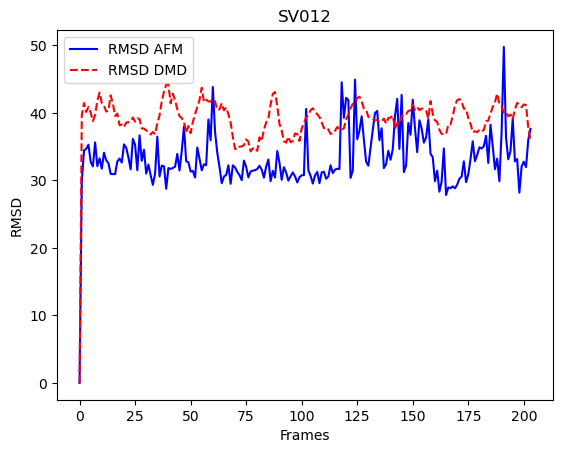

In [30]:
# Calculate RMSD for AFM y DMD using the first frame as reference
reference_afm = frames[0]
reference_dmd = optdmd.reconstructed_data[:, 0].reshape(frames.shape[1], frames.shape[2])

rmsd_afm = compute_rmsd_series(frames, reference_afm)
rmsd_dmd = compute_rmsd_series(
    optdmd.reconstructed_data.T.reshape(frames.shape[0], frames.shape[1], frames.shape[2]),
    reference_dmd
)

# Graficar ambas series de RMSD

plt.plot(rmsd_afm, label="RMSD AFM", color="blue"); plt.plot(rmsd_dmd, label="RMSD DMD", color="red", linestyle="--");
plt.xlabel("Frames"); plt.ylabel("RMSD"); plt.title('SV012')
plt.savefig('output_RMSD_AFM_dmd_SV012.png'); plt.legend(); plt.show()

In [31]:
output_folder = "aux"
os.makedirs(output_folder, exist_ok=True)

frames_total = frames.shape[0]  
frame_size = frames.shape[1]  

gif_frames = []

for i in range(frames_total):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.real(X[:, i]).reshape(frame_size, frame_size), cmap="inferno")
    ax[0].set_title(f"Original - Frame {i}")
    ax[0].set_axis_off()
    ax[1].imshow(np.real(optdmd.reconstructed_data[:, i]).reshape(frame_size, frame_size), cmap="inferno")
    ax[1].set_title(f"DMD - Frame {i}")
    ax[1].set_axis_off()
    img_path = os.path.join(output_folder, f"frame_{i:04d}.png")
    plt.savefig(img_path, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    gif_frames.append(imageio.v2.imread(img_path))
    
gif_path = f"spike_umbral{umbral}.gif"
gif_speed = 0.2  # Velocidad

imageio.mimsave(gif_path, gif_frames, duration=gif_speed)
#shutil.rmtree(output_folder)

In [32]:
# Visualizacion del gif

gif_path = f"spike_umbral{umbral}.gif"
timestamp = int(time_module.time()) 
gif_path_with_timestamp = f"{gif_path}?t={timestamp}"

html_code = f'''
    <html>
        <body>
            <img src="{gif_path_with_timestamp}" width="800" height="800" style="display:block" loop="true" autoplay="true"/>
        </body>
    </html>
'''

HTML(html_code)

In [33]:

def calcu_all(path,areaNoise):
    cap = cv2.VideoCapture(path)
    
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        exit()
    
    # Parameters
    min_area = areaNoise  # Minimum area threshold to filter noise
    frame_size = (100, 100)  # Common size for averaging shapes  Def=200
    z_thre=100  # by default 127
    # Lists to store data
    area_per_frame = []
    rotation_per_frame = []
    average_shape_accumulator = np.zeros(frame_size, dtype=np.float32)
    shape_count = 0  # Number of valid shapes accumulated
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit loop when video ends
    
        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
        # Apply binary thresholding
        _, thresh = cv2.threshold(gray, z_thre, 255, cv2.THRESH_BINARY) #change lower filter to 100?
    
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Filter out small areas
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]
        
        # Compute total area per frame
        total_area = sum(cv2.contourArea(contour) for contour in filtered_contours)
        area_per_frame.append(total_area)
    
        # Store rotation angles per frame
        angles = []
    
        for contour in filtered_contours:
            area = cv2.contourArea(contour)
    
            # Get the minimum area rectangle
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)  # Get corner points
            box = np.intp(box)  # Convert to integer
    
            # Extract rotation angle
            angle = rect[2]
            if rect[1][0] < rect[1][1]:  # Width < Height
                angle += 90  
            angles.append(angle)
    
            # Draw rotated bounding box
            cv2.drawContours(frame, [box], 0, (0, 255, 0), 2)
            cv2.putText(frame, f"Angle: {int(angle)}°", (box[0][0], box[0][1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
    
            # Normalize shape for averaging
            mask = np.zeros_like(thresh)
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
            # Resize to common shape size
            x, y, w, h = cv2.boundingRect(contour)
            shape_cropped = mask[y:y+h, x:x+w]
            shape_resized = cv2.resize(shape_cropped, frame_size, interpolation=cv2.INTER_AREA)
    
            # Accumulate shapes
            average_shape_accumulator += shape_resized
            shape_count += 1
    
        # Store average rotation angle (if there are detected contours)
        rotation_per_frame.append(np.mean(angles) if angles else 0)
    
        # Display total area and average rotation angle
        cv2.putText(frame, f"Total Area: {int(total_area)} px^2", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        cv2.putText(frame, f"Avg Angle: {int(rotation_per_frame[-1])}°", (50, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        #cv2.imshow("Segment Area & Rotation Detection", frame)
    
        # Press 'q' to quit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    
    # Convert lists to NumPy arrays
    area_per_frame = np.array(area_per_frame)
    rotation_per_frame = np.array(rotation_per_frame)
    
    # Compute final average shape
    if shape_count > 0:
        average_shape = (average_shape_accumulator / shape_count).astype(np.uint8)
    
        # Display the averaged shape
        #cv2.imshow("Average Segmented Shape", average_shape)
        cv2.imwrite("average_shape_1.png", average_shape)
        cv2.waitKey(0)
    
    # Print results
    print("Total Area per Frame:", area_per_frame)
    print("Rotation per Frame (degrees):", rotation_per_frame)
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
        
    return area_per_frame,rotation_per_frame

In [34]:
areaTpframe2,rotTpframe2 = calcu_all('spikes/Horcaio-spike.avi',100)  #min area to filter is given in a.u.
areaTpframe2 = areaTpframe2[12:216]
rotTpFram2=rotTpframe2[12:216]

Total Area per Frame: [ 831.  1227.5 1068.   653.   700.   834.5 1036.  1098.  1460.  1300.5
 1429.5 1371.5 1116.5 1517.5  894.5  783.   867.5  728.5  811.   893.5
  916.   867.5 1045.5 1245.   877.5 1030.5  984.   954.   949.5  965.5
  807.5  936.   894.5 1079.5  719.5  704.5 1104.  1217.5 1007.  1154.
 1074.5  936.5  874.5  942.  1100.   872.   730.   665.5  718.5  845.
 1066.   898.  1002.5 1038.5  934.  1077.5  985.5  819.5  929.5 1089.
 1051.   877.5  989.5  832.5  816.5  814.5 1037.   789.5  929.5  603.5
 1149.   896.  1127.5  853.5  865.   899.   916.5  810.5  820.5  681.5
  822.   644.   665.   698.5  714.5  743.5  669.5  766.   738.5  752.5
  645.   649.5  625.5  636.5  725.5  732.   739.5  640.5  674.5  675.5
  755.  1000.5  655.5  864.5  791.5  773.5  730.   722.5  764.   816.
  792.   703.5  652.   876.   920.   979.   790.5  763.   734.5  734.5
  808.5  784.5  633.   696.   697.5  946.5  736.5  758.5  663.   645.
  813.5  691.   670.5  705.5  531.5  701.   727.   648.5  69

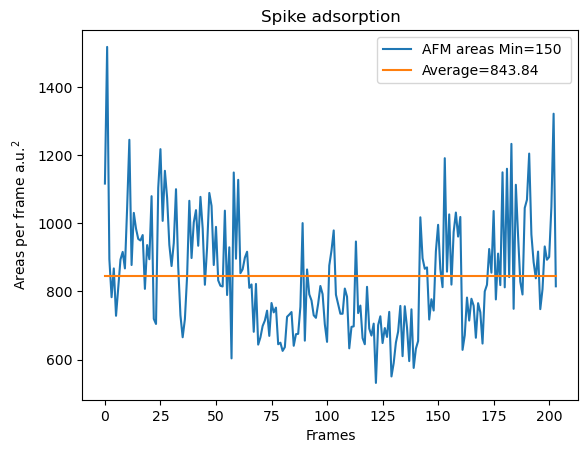

min 531.5
max 1517.5
mean 843.8357843137255


In [35]:
plt.plot(areaTpframe2, label="AFM areas Min=150 ");plt.plot(np.ones(areaTpframe2.size)*areaTpframe2.mean(), label="Average="+str(np.round(areaTpframe2.mean(),2)))
plt.xlabel("Frames"); plt.ylabel("Areas per frame a.u.$^2$");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_areas.png');
plt.show();
print("min",areaTpframe2.min())
print("max",areaTpframe2.max())
print("mean",areaTpframe2.mean())


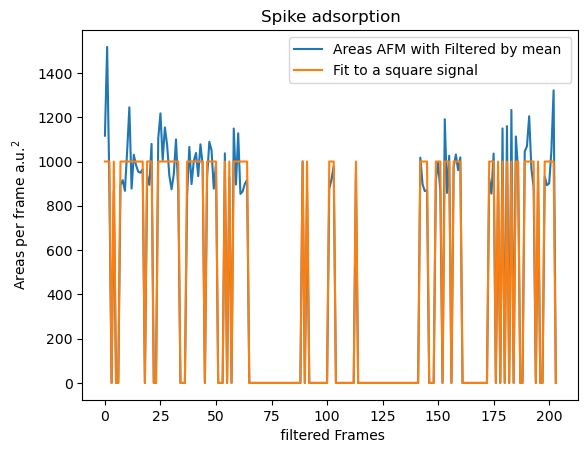

min 0.0
max 1517.5
mean 438.1397058823529


In [36]:
umbralAreas = areaTpframe2.mean() #parameter to try to get rid of the noise!
areaTpframeFilt= np.where(areaTpframe2 < umbralAreas, 0, areaTpframe2)
plt.plot(areaTpframeFilt, label="Areas AFM with Filtered by mean "); plt.plot(np.where(areaTpframeFilt>areaTpframeFilt.mean(),1000,0), label="Fit to a square signal")
plt.xlabel(" filtered Frames"); plt.ylabel("Areas per frame a.u.$^2$");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_areas.png');
plt.show();
print("min",areaTpframeFilt.min())
print("max",areaTpframeFilt.max())
print("mean",areaTpframeFilt.mean())

In [37]:
indexesHigh=np.array(range(0,204))*np.where(areaTpframeFilt>areaTpframeFilt.mean(),1,0)
print(indexesHigh)
type(indexesHigh)
transition_indices = np.where((indexesHigh[:-1] == 0) & (indexesHigh[1:] != 0))[0] + 1

outTransIdexes=indexesHigh[transition_indices]
print(outTransIdexes)
print(outTransIdexes.size)

[  0   1   2   0   4   0   0   7   8   9  10  11  12  13  14  15  16  17
   0  19  20  21   0   0  24  25  26  27  28  29  30  31  32  33   0   0
   0  37  38  39  40  41  42  43  44   0  46  47  48  49  50   0   0   0
  54   0  56   0  58  59  60  61  62  63  64   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  89
   0  91   0   0   0   0   0   0   0   0   0 101 102 103   0   0   0   0
   0   0   0   0   0 113   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 142 143
 144 145   0   0   0 149 150 151   0 153 154 155   0 157 158 159 160   0
   0   0   0   0   0   0   0   0   0   0   0 173 174 175   0 177   0 179
   0 181   0 183   0 185 186   0   0 189 190 191 192 193   0 195   0   0
 198 199 200 201 202   0]
[  1   4   7  19  24  37  46  54  56  58  89  91 101 113 142 149 153 157
 173 177 179 181 183 185 189 195 198]
27


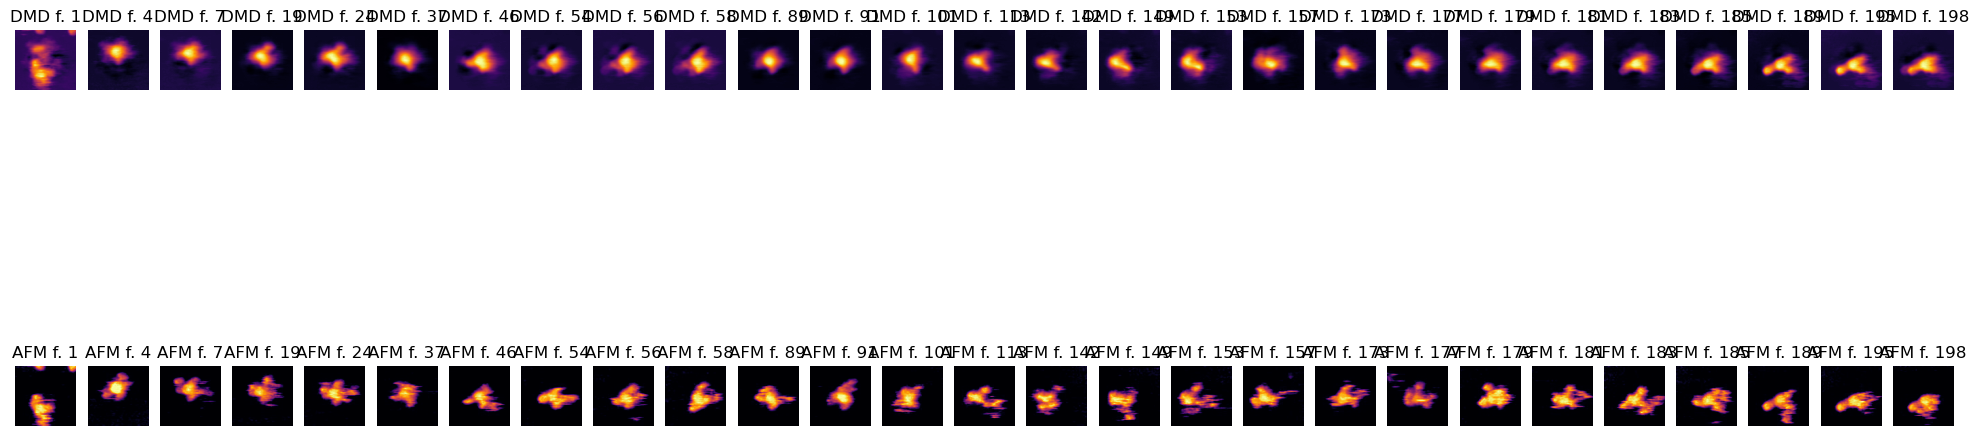

In [38]:
fig, axs = plt.subplots(2,outTransIdexes.size,figsize=(25,8))
timesteps = outTransIdexes
for i in range(0,outTransIdexes.size):
    axs[0,i].imshow(np.real(optdmd.reconstructed_data[:,outTransIdexes[i]]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
    axs[1,i].imshow(np.real(X[:,outTransIdexes[i]]).reshape(frames.shape[1],frames.shape[1]),cmap='inferno')
    axs[0,i].set_title(f'DMD f. {timesteps[i]}');
    axs[1,i].set_title(f'AFM f. {timesteps[i]}');
    axs[0,i].set_axis_off()
    axs[1,i].set_axis_off()
plt.show()    
fig.savefig('afm_area_reconstruction_sarah.png')     

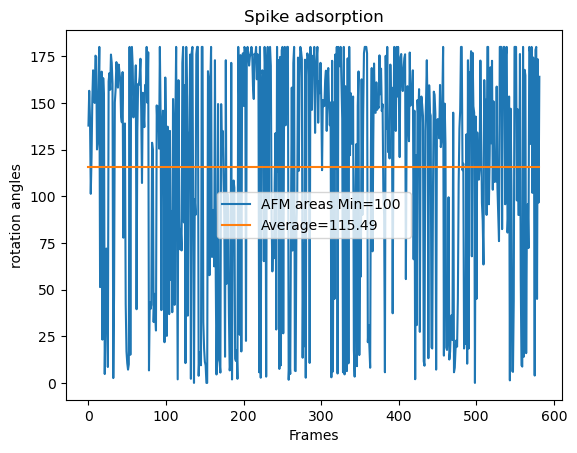

min 0.0
max 180.0
mean 115.48778762222017


In [39]:
plt.plot(rotTpframe2, label="AFM areas Min=100 ");plt.plot(np.ones(rotTpframe2.size)*rotTpframe2.mean(), label="Average="+str(np.round(rotTpframe2.mean(),2)))
plt.xlabel("Frames"); plt.ylabel("rotation angles");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_areas.png');
plt.show();
print("min",rotTpframe2.min())
print("max",rotTpframe2.max())
print("mean",rotTpframe2.mean())

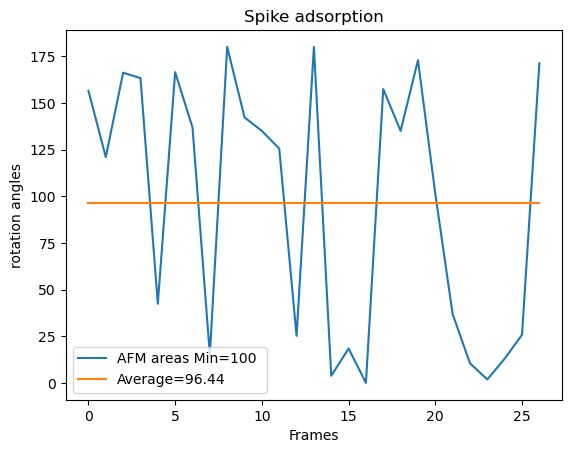

min 0.0
max 180.0
mean 96.43680022822485


In [40]:
plt.plot(rotTpframe2[outTransIdexes], label="AFM areas Min=100 ");plt.plot(np.ones(rotTpframe2[outTransIdexes].size)*rotTpframe2[outTransIdexes].mean(), label="Average="+str(np.round(rotTpframe2[outTransIdexes].mean(),2)))
plt.xlabel("Frames"); plt.ylabel("rotation angles");
plt.title('Spike adsorption')
plt.legend();
plt.savefig(f'outputs_RoG_AFM_areas.png');
plt.show();
print("min",rotTpframe2[outTransIdexes].min())
print("max",rotTpframe2[outTransIdexes].max())
print("mean",rotTpframe2[outTransIdexes].mean())

To efficiently obtain the area of a segment in a picture, consider these methods:

1. Thresholding & Contour Detection
Algorithm:
Convert the image to grayscale.
Apply thresholding (e.g., Otsu’s method or adaptive thresholding).
Use contour detection (e.g., OpenCV’s cv2.findContours()).
Compute area using cv2.contourArea().
Best for: Simple and well-separated objects.
2. Edge Detection & Flood Fill
Algorithm:
Use edge detection (Canny or Sobel filters).
Apply flood fill from a known point within the segment.
Count pixels belonging to the filled region.
Best for: Segments with clear boundaries.
3. Region Growing
Algorithm:
Select a seed pixel.
Expand the region iteratively based on similarity.
Count the number of pixels in the final region.
Best for: Objects with gradual transitions.
4. Watershed Algorithm
Algorithm:
Apply gradient detection (e.g., Sobel operator).
Compute distance transform for foreground detection.
Use marker-based watershed segmentation.
Compute the area of identified segments.
Best for: Overlapping objects.
5. Deep Learning-Based Segmentation (U-Net, Mask R-CNN)
Algorithm:
Train a CNN-based model on labeled images.
Use the model to predict the segment mask.
Compute area as the number of pixels in the mask.
Best for: Complex images with varying shapes and textures.
6. K-Means Clustering
Algorithm:
Convert image to Lab or HSV color space.
Apply K-Means clustering to segment colors.
Select the cluster corresponding to the target segment.
Compute area by counting pixels.
Best for: Color-based segmentation.
Which One is Most Efficient?
For real-time applications: Thresholding + Contour Detection.
For complex shapes: Watershed or Region Growing.
For noisy images: Deep Learning (U-Net, Mask R-CNN).
Would you like implementation details in Python? 🚀
